<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Unet/blob/master/Unet_automatic_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bubble segementation using Unet: inference model

In [1]:
#@title If you use google colab, first click on "ouvrir en mode brouillon" on the upper panel and run this block (click on this text and Ctrl+Entre). This will install the framwork. { run: "auto" }

%tensorflow_version 1.x
!git clone https://github.com/larrygoyeau/bubble_segmentation_Unet

import logging
logging.getLogger('tensorflow').disabled = True

# Install required libs
import os
os.system('pip install albumentations==0.4.5')
os.system('pip install -U efficientnet==1.0.0')
os.system('pip install image-classifiers==1.0.0')
os.system('pip install -U segmentation-models==1.0.0')

import sys
import random
from google.colab import files
import cv2
import keras
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm
import resource

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    
    def __init__(
            self, 
            image=None,
            images_dir=None,
            preprocessing=None,
            augmentation=None,
    ):
        self.ids_image = os.listdir(images_dir)
        
        if images_dir!=None:
          self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_image]
        else:
          self.images_fps=None
   
        self.preprocessing = preprocessing

        self.augmentation=augmentation

        self.image=image
    
    def __getitem__(self, i):
        
        # read data
        if self.images_fps!=None:
          image = cv2.imread(self.images_fps[i])
        else:
          image = self.image
        if len(image)>2**11:
          image=image[:2**11,:]
        if len(image[0])>2**11:
          image=image[:,:2**11]
        shape_image=image.shape
        p=255/(image.max()-image.min())
        image=(image-image.min())*p
        image= image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.augmentation:
          I=len(image)
          J=len(image[0])
          sample = self.augmentation(I,J)(image=image)
          image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image= sample['image']
            
        return image, shape_image
        
    def __len__(self):
        return len(self.ids_image)

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)


def get_validation_augmentation(I,J):
    """Add paddings"""
    if I>384 or J>544:
      test_transform = [A.PadIfNeeded(2**(int(np.log(I-1)/np.log(2))+1), 2**(int(np.log(J-1)/np.log(2))+1), border_mode=0)]
    else:
      test_transform = [A.PadIfNeeded(384, 544, border_mode=0)]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)
LR = 0.0001

# define network parameters
n_classes =3 # case for binary and multiclass segmentation
activation = 'softmax'

# define optimizer
optim = keras.optimizers.Adam(LR)

json_file = open('/content/bubble_segmentation_Unet/best_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model, you can change the path if you don't use colab
model.load_weights("/content/bubble_segmentation_Unet/best_model.h5")
print("Loaded model from disk")

# compile keras model with defined optimozer, loss and metrics
model.compile(optim,loss='categorical_crossentropy')

resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

def color_bubble(mask,i,j,I,J,random_color,color):
  if all(mask[i,j]==color) and (i,j)!=(0,0):
    if i==I-1 or j==J-1 or i==0 or j==0:
      mask[0,0][1]=mask[0,0][1]+1 #number of pixel in contacte with the border
    mask[0,0][0]=mask[0,0][0]+1   #size bubble
    mask[i,j]=random_color
    if 0<j:
      color_bubble(mask,i,j-1,I,J,random_color,color)
    if i<I-1:
      color_bubble(mask,i+1,j,I,J,random_color,color)
    if 0<i:
      color_bubble(mask,i-1,j,I,J,random_color,color)
    if j<J-1:
      color_bubble(mask,i,j+1,I,J,random_color,color)
    
def uncolor_bubble(mask,i,j,I,J,color_liquide,random_color):
  if all(mask[i,j]==random_color):
    mask[i,j]=color_liquide
    if 0<j:
      uncolor_bubble(mask,i,j-1,I,J,color_liquide,random_color)
    if i<I-1:
      uncolor_bubble(mask,i+1,j,I,J,color_liquide,random_color)
    if 0<i:
      uncolor_bubble(mask,i-1,j,I,J,color_liquide,random_color)
    if j<J-1:
      uncolor_bubble(mask,i,j+1,I,J,color_liquide,random_color)
    
# The fonuction bellow select a good color for bubble

def the_color(random_color,threshold):
  if random_color[0]-random_color[1]<threshold and random_color[0]-random_color[2]<threshold:
    random_color=[random.randint(4, 255),random.randint(4, 255),random.randint(4, 255)]
    return(the_color(random_color,threshold))
  else:
    return(random_color)
    
# The fonuction bellow will color each bubbles and return the size of each bubbles

def foam(mask,color_air,threshold,color_liquide,image_name,remove_bubbles_on_the_border):
  file = open(image_name[:-4]+".txt","w")
  file.write("Bubble index and its size\n")
  I=len(mask)
  J=len(mask[0])
  bubble=0
  size_of_bubbles=[]
  for i in range(I):
    for j in range(J):
      if all(mask[i,j]==color_air):
        mask[0,0][0]=0 #size of bubbles
        mask[0,0][1]=0 #number of pixel in contacte with the border
        random_color=[random.randint(4, 255),random.randint(4, 255),random.randint(4, 255)]
        random_color=the_color(random_color,60)
        color_bubble(mask,i,j,I,J,random_color,color_air)
        size_bubble=int(mask[0,0][0])
        if len(size_of_bubbles)>3 and size_bubble<threshold*sum(size_of_bubbles)/len(size_of_bubbles):
          uncolor_bubble(mask,i,j,I,J,color_liquide,random_color)
        elif mask[0,0][1]>0 and remove_bubbles_on_the_border:
          uncolor_bubble(mask,i,j,I,J,color_liquide,random_color)
        else:
          bubble=bubble+1
          size_of_bubbles=size_of_bubbles+[size_bubble]
          file.write(str(bubble)+"  "+str(size_bubble)+"\n")
  file.close() 
  print("Number of detected bubbles "+str(bubble))
  return(size_of_bubbles)

def segment_image(uploaded,remove_bubbles_on_the_border):
  
  size_of_bubbles=[]
  
  for image_uploaded in uploaded:
    print('\n')
    path=os.path.join('/content', image_uploaded)
    image=cv2.imread(path)
    path=path.replace(' ', '\ ')
    os.system('rm '+path)

    test_dataset = Dataset(
      image=image,
      preprocessing=get_preprocessing(preprocess_input),
      augmentation=get_validation_augmentation
    )

    image, shape_image= test_dataset[0]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()[0]
    
    image=image[0]
    image=image[int((len(image)-shape_image[0])/2):int((len(image)-shape_image[0])/2)+shape_image[0]]
    image=image[:,int((len(image[0])-shape_image[1])/2):int((len(image[0])-shape_image[1])/2)+shape_image[1]]
    pr_mask=pr_mask[int((len(pr_mask)-shape_image[0])/2):int((len(pr_mask)-shape_image[0])/2)+shape_image[0]]
    pr_mask=pr_mask[:,int((len(pr_mask[0])-shape_image[1])/2):int((len(pr_mask[0])-shape_image[1])/2)+shape_image[1]]
    
    size_of_bubbles=size_of_bubbles+foam(pr_mask[:,:-1], color_air=[1,0,0],threshold=0.015,color_liquide=[0,1,0], image_name=image_uploaded, remove_bubbles_on_the_border=remove_bubbles_on_the_border)
    
    image=denormalize(image.squeeze())
    I=len(image)
    J=len(image[0])
    mask_plus_image=pr_mask.copy()
    mask=pr_mask.copy()
    for i in range(I):
      for j in range(J):
        if pr_mask[i,j][2]==1.0 or pr_mask[i,j][1]==1.0 or all(pr_mask[i,j]==0):
          mask_plus_image[i,j]=image[i,j]*255
          mask[i,j]=0
    
    visualize(mask_plus_image=denormalize(mask_plus_image.squeeze()))
    cv2.imwrite('mask_plus_'+image_uploaded[:-3]+'png', mask_plus_image)
    cv2.imwrite('mask_of_'+image_uploaded[:-3]+'png', mask)
  return(size_of_bubbles)

TensorFlow 1.x selected.
Cloning into 'bubble_segmentation_Unet'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1015 (delta 45), reused 0 (delta 0), pack-reused 934
Receiving objects: 100% (1015/1015), 339.24 MiB | 32.83 MiB/s, done.
Resolving deltas: 100% (619/619), done.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Loaded model from disk


In [0]:
#@title Do you want to remove the bubbles that are in contact with the outline of the images? { run: "auto" }

Select_the_answer_and_run_this_block = 'No' #@param ["Yes", "No"]

if Select_the_answer_and_run_this_block=='Yes':
  remove_bubbles_on_the_border=True
else:
  remove_bubbles_on_the_border=False

Now run the block below. Then click on “select fichiers” and select (several) images that you want to segment from your device. The segmented images are saved on the left panel 'fichier'. Click on 'actualliser' and the file will appear. These files are:


*   mask_plus_image_name.png $ $ $ $ for the segmentation plus the image
*   mask_of_image_name.png $ $ $ $ for the mask only
* image_name.txt $ $ $ $ for the description of each bubble detected on the image



 You can download them by right clicking on them and select 'telecharger'. If you get an error run once again or tell me.


Saving photo 6.png to photo 6.png
Saving photo 12.png to photo 12.png


Number of detected bubbles 197


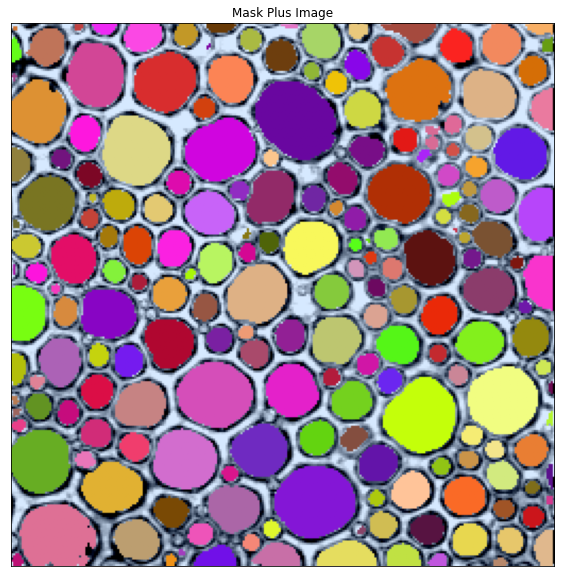



Number of detected bubbles 177


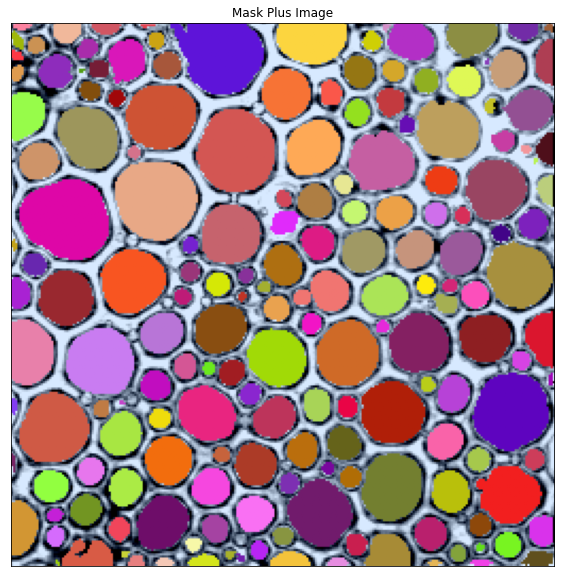

In [3]:
#@title Run this block { run: "auto" }

uploaded = files.upload()
size_of_bubbles=segment_image(uploaded,remove_bubbles_on_the_border)

For the distribution of the size of bubbles, run the block below. The historame is save as size_distribution.png

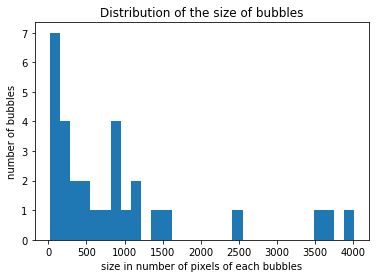

In [0]:
plt.hist(size_of_bubbles,bins = 30)
plt.xlabel('size in number of pixels of each bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")